In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing MNIST dataset from scikit-learn library

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X = mnist['data']
y = mnist['target']

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
#X is a dataset having 70000 images and each image has 784 features.
#784 features refers to the image size of 28X28 pixels

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
# y consists of the actual digits represented each 70000 images

y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
y = y.astype(np.uint8)   #Since y labels are strings, we need to make them integers

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
#To verify 
sgd.predict([X[4]])

array([ True])

In [13]:
#Above prediction says the digit in X[4] is indeed 9
#Lets check:-
y[4]

9

In [14]:
#So it works correctly
#Lets test on another digit
print(y[2])
sgd.predict([X[2]])

4


array([False])

In [15]:
#Seeing our model works correctly, we still need to measure its performance
#Hence now we will perform its PERFORMANCE MEASURE using K-fold Cross Validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [16]:
# 87% accuracy...Not that good accuracy percentage but does it accurately depict the accuracy?
# scoring='accuracy' measure isn't a good method especially for datasets where the distribution is partial
# For example the no. of 9s are far less than no. of non-9s. Hence predicting non-9 class is far very easy
# and will obviously have high accuracy.

#We see the no. of 9s are 1009
#and no. of non 9s are 8991

np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
       dtype=int64))

In [17]:
# We need another method: Confusion Matrix
# For confusion matrix, we need to get the set of predictions instead of set of scores
# Hence we use cross_val_predict instead of cross_val_score

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_9, cv=3)

In [18]:
#Implementing Confusion Matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]], dtype=int64)

In [19]:
#TP: 4254
#TN: 52715
#FP: 1336
#FN: 1695

#Precision = TP/(TP+FP)
#Recall = TP/(TP+FN)

In [20]:
#Calculating Precision

from sklearn.metrics import precision_score
precision_score(y_train_9, y_train_pred)

0.7610017889087657

In [21]:
#Calculating Recall

from sklearn.metrics import recall_score
recall_score(y_train_9, y_train_pred)

0.7150781643973777

In [22]:
#Calculating F1 score

from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.737325591472398

In [23]:
y_scores = cross_val_predict(sgd, X_train, y_train_9, cv=3, method='decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recall, thresholds = precision_recall_curve(y_train_9, y_scores)

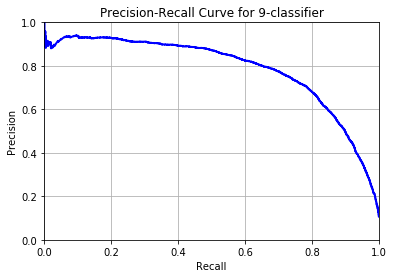

In [25]:
#PR curve
plt.plot(recall, precisions, 'b-', linewidth=2)
plt.title('Precision-Recall Curve for 9-classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0,1,0,1])
plt.grid(True)

In [26]:
#Now from P-R curve we see at around 75-80% recall, there is a sharp decrease in the precision
#Hence for good precision-recall tradeoff, we select a recall before that drop, ie. at 60% recall

#But if we want a 90% precision, we have to vary the threshold
#To find the perfect threshold:

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)

4255.561354287602


In [27]:
#At a threshold of around 4256 we get a 90% precision. Lets check

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_9, y_train_pred_90))
print(recall_score(y_train_9, y_train_pred_90))

0.9001728608470182
0.3501428811564969


In [28]:
# Therefore we got a 90% precision by increasing the threshold
# But as a result we decreased the recall percentage to about 35%.
# A high precision classifier isn't good if it has too low recall

In [29]:
# ROC Curves:
# ROC Curve is common in binary classifiers
# It plots TPR(recall) v/s FPR 

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

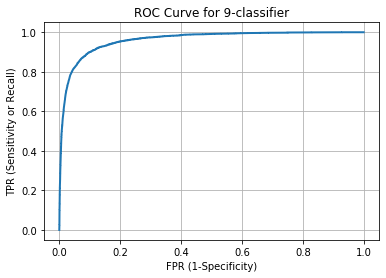

In [30]:
plt.plot(fpr, tpr, linewidth=2)
plt.title('ROC Curve for 9-classifier')
plt.xlabel('FPR (1-Specificity)')
plt.ylabel('TPR (Sensitivity or Recall)')
plt.grid(True)

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.96114559368217

In [32]:
# Lets take a diff model to try to increase the roc_score
# Taking Random Forest Model

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method='predict_proba')

In [33]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9,y_scores_forest)

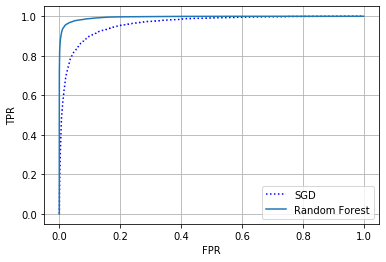

In [34]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.legend(loc='lower right')

In [35]:
# We see since the Random Forest is very much close to the top-left than
# the SGD, we conclude RF is a better model than SGD 

In [36]:
roc_auc_score(y_train_9, y_scores_forest)

0.9952328942154235

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)
print(precision_score(y_train_9, y_train_pred_forest))
print(recall_score(y_train_9, y_train_pred_forest))

0.9819324430479183
0.8404773911581779


In [ ]:
# We see we got a higher ROC score of about 99.5%
# We see we got a higher precision score of about 98.2%
# We see we got a lot higher recall score of about 84%